# Notebook demonstrating fitting of $hrz0$ to site data
The below code shows how to use data from fixed-tilt experiments to compute the free parameter $hrz0$. The dust distribution is currently assumed and its parameters are defined in the file `parameters_qut_experiments.xlsx`.

In [1]:
import numpy as np
import soiling_model.base_models as smb
import soiling_model.fitting as smf
import soiling_model.utilities as smu
from matplotlib import rcParams
import pickle
from scipy.stats import norm
rcParams['figure.figsize'] = (10, 7)
# %matplotlib qt

sp_save_file = "results/sp_fitting_results"
cm_save_file = "results/cm_fitting_results"
reflectometer_incidence_angle = 15 # angle of incidence of reflectometer
reflectometer_acceptance_angle = 12.5e-3 # half acceptance angle of reflectance measurements
k_factor = 2.404 # calibration factor for TSP measurements in experiments
second_surf = True # True if using the second-surface model. Otherwise, use first-surface
d = "data/public/qut_experiments/"
files = [   'experiment_20170807_20170811_cinque.xlsx','experiment_20170828_20170901_cinque.xlsx',\
            'experiment_20170905_20170913_cinque.xlsx','experiment_20170915_20170921_cinque.xlsx']
training_intervals = [  np.array(['2017-08-07T00:00:00','2017-08-12T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-08-28T00:00:00','2017-09-02T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-09-05T00:00:00','2017-09-13T00:00:00'],dtype=np.datetime64),
                        np.array(['2017-09-15T00:00:00','2017-09-21T00:00:00'],dtype=np.datetime64)]
parameter_file = d+"parameters_qut_experiments.xlsx"

## Load in data and divide into training and testing

Specify mirrors for training, the k-factors of the dust measurements (if any), and the type of dust measurement (PMX or TSP).

In [2]:
train_experiments = [1] # indices for training experiments from 0 to len(files)-1
train_mirrors = ["Mirror_1"] # which mirrors within the experiments are used for training
all_mirrors = ["Mirror_"+str(i+1) for i in range(5)]

files_experiment = [d+files[ii] for ii in range(len(files))]
Nfiles = len(files_experiment)
k_factors = [k_factor]*Nfiles
incidence_angle = [reflectometer_incidence_angle]*Nfiles
acceptance_angle = [reflectometer_acceptance_angle]*Nfiles
dust_types = ["TSP"]*Nfiles

extract = lambda x,ind: [x[ii] for ii in ind]
files_experiment_train = extract(files_experiment,train_experiments)
training_intervals = extract(training_intervals,train_experiments)
k_factors_train = extract(k_factors,train_experiments)
dust_types_train = extract(dust_types,train_experiments)
incidence_angle_train = extract(incidence_angle,train_experiments)
acceptance_angle_train = extract(acceptance_angle,train_experiments)
t = [t for t in train_experiments]
training_string = "Training: "+str(train_mirrors)+", Exp: "+str(t)

Instantiate model and load in training data

In [3]:
imodel = smf.semi_physical(parameter_file)
sim_data_train = smb.simulation_inputs( files_experiment_train,
                                        k_factors=k_factors_train,
                                        dust_types=dust_types_train
                                        )
reflect_data_train = smb.reflectance_measurements(  files_experiment_train,
                                                    sim_data_train.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=incidence_angle_train,
                                                    reflectometer_acceptance_angle=acceptance_angle_train,
                                                    import_tilts=True,
                                                    column_names_to_import=train_mirrors
                                                    )


Importing constants
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing dust properties for each experiment
Loading source (normalized) intensity from data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx


Trim training data to specified ranges. The second trim ensures that the weather variables stop at the limits of the reflectance data

In [4]:
            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                training_intervals 
                                                            )
                                                            
sim_data_train,reflect_data_train = smu.trim_experiment_data(   sim_data_train,
                                                                reflect_data_train,
                                                                "reflectance_data" 
                                                            )


Load in the total data

In [5]:

sim_data_total = smb.simulation_inputs( files_experiment,
                                        k_factors=k_factors,
                                        dust_types=dust_types
                                        )

reflect_data_total = smb.reflectance_measurements(  files_experiment,
                                                    sim_data_total.time,
                                                    number_of_measurements=9.0,
                                                    reflectometer_incidence_angle=incidence_angle,
                                                    reflectometer_acceptance_angle=acceptance_angle,
                                                    import_tilts=True,
                                                    column_names_to_import=None
                                                    )


Importing site data (weather,time). Using dust_type = TSP, test_length = 102 hours
Length of simulation for file data/public/qut_experiments/experiment_20170807_20170811_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 96 hours
Length of simulation for file data/public/qut_experiments/experiment_20170828_20170901_cinque.xlsx: 4.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 200 hours
Length of simulation for file data/public/qut_experiments/experiment_20170905_20170913_cinque.xlsx: 8.0 days
No DNI data to import. Skipping.
No rain intensity data to import.
No relative humidity data to import.
Importing site data (weather,time). Using dust_type = TSP, test_length = 154 hours
Length of simulation for file 

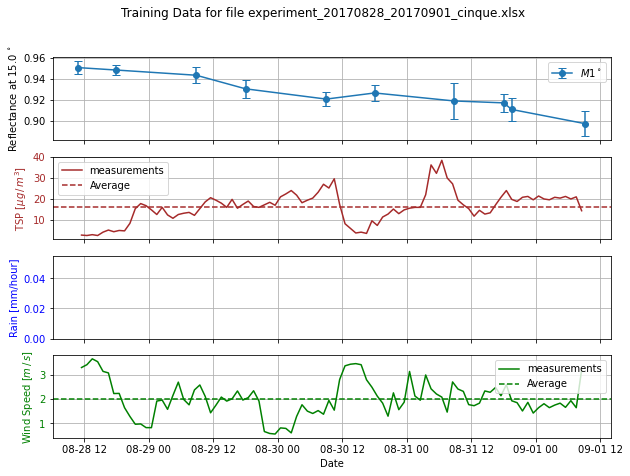

In [6]:
for ii,experiment in enumerate(train_experiments):
    fig,ax = smu.plot_experiment_data(sim_data_train,reflect_data_train,ii)
    fig.suptitle(f"Training Data for file {files[experiment]}")

### Compute extinction weights for both simulation datasets and plot. 
Note that the extinction weights depend only on the refractive index. If the refractive index is the same for all experiments, all extinction weights will be the same (and the computation will be faster.)

In [7]:
imodel.helios_angles(sim_data_train,reflect_data_train,second_surface=second_surf)
imodel.helios.compute_extinction_weights(sim_data_train,imodel.loss_model,verbose=True)

Setting tilts for 1 experiments
Second surface model
Loss Model is mie. Computing extinction coefficients ... 
	 Computing weights for file 0, heliostat 0...
	 Acceptance angle cosine = 0.999922
... Done!


Plot extinction weights and save for later, since extinction weights are the same for all files in this example.

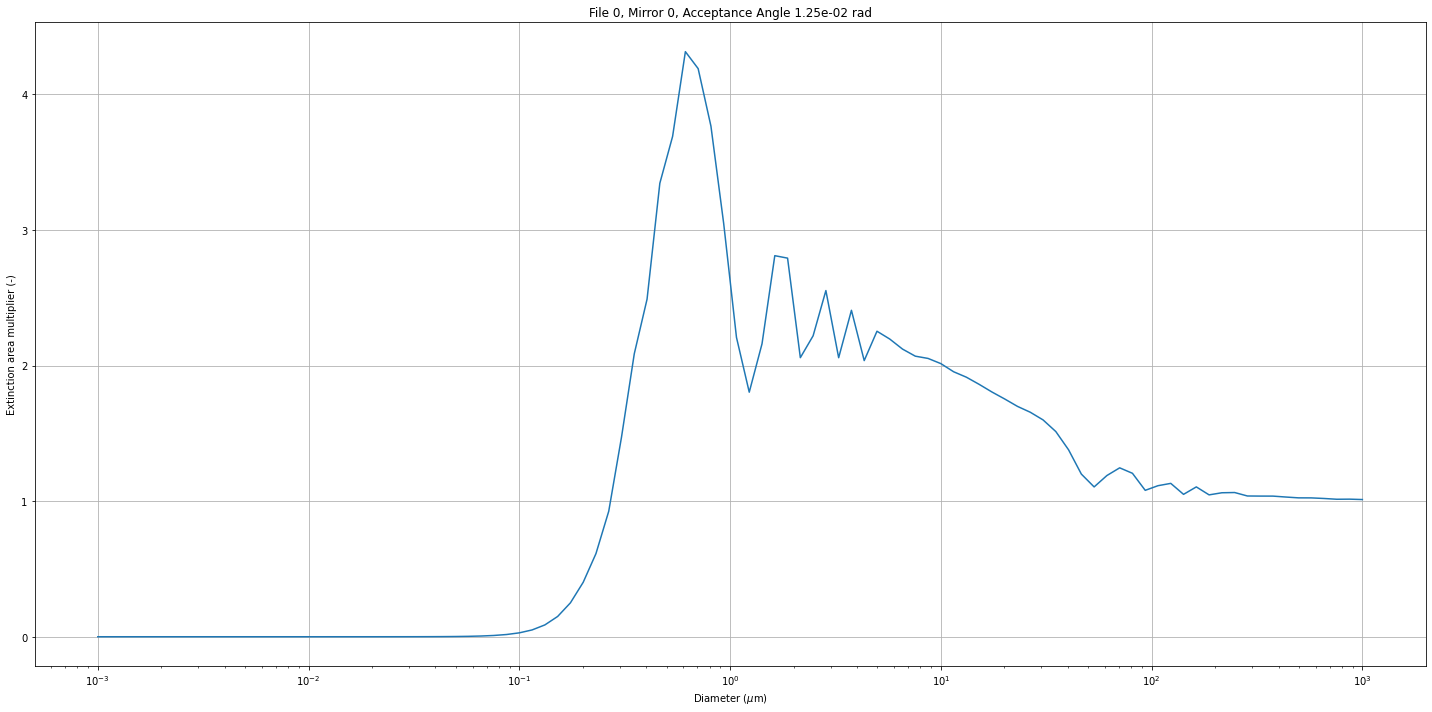

In [8]:
imodel.helios.plot_extinction_weights(sim_data_train,fig_kwargs={'figsize':(20,10)})
ext_weights = imodel.helios.extinction_weighting[0].copy()

# Fit non-stochastic model

In [9]:
hrz0_multi,sse_multi = imodel.fit_least_squares(sim_data_train,reflect_data_train)
imodel.update_model_parameters(hrz0_multi)

Fitting hrz0 with least squares ...
... done! 
 hrz0 = 1.815945434886682


Set extinction coefficients. Instead of computing, we set them directly using set_extinction_coefficients since we know that they are all the same (because the dust and acceptance angles of the measurement are all the same).

In [10]:
imodel.helios_angles(sim_data_total,reflect_data_total,second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(sim_data_total,imodel.loss_model,verbose=True) 

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)


Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


No value for hrz0 supplied. Using value in self.hrz0 = 1.815945434886682.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


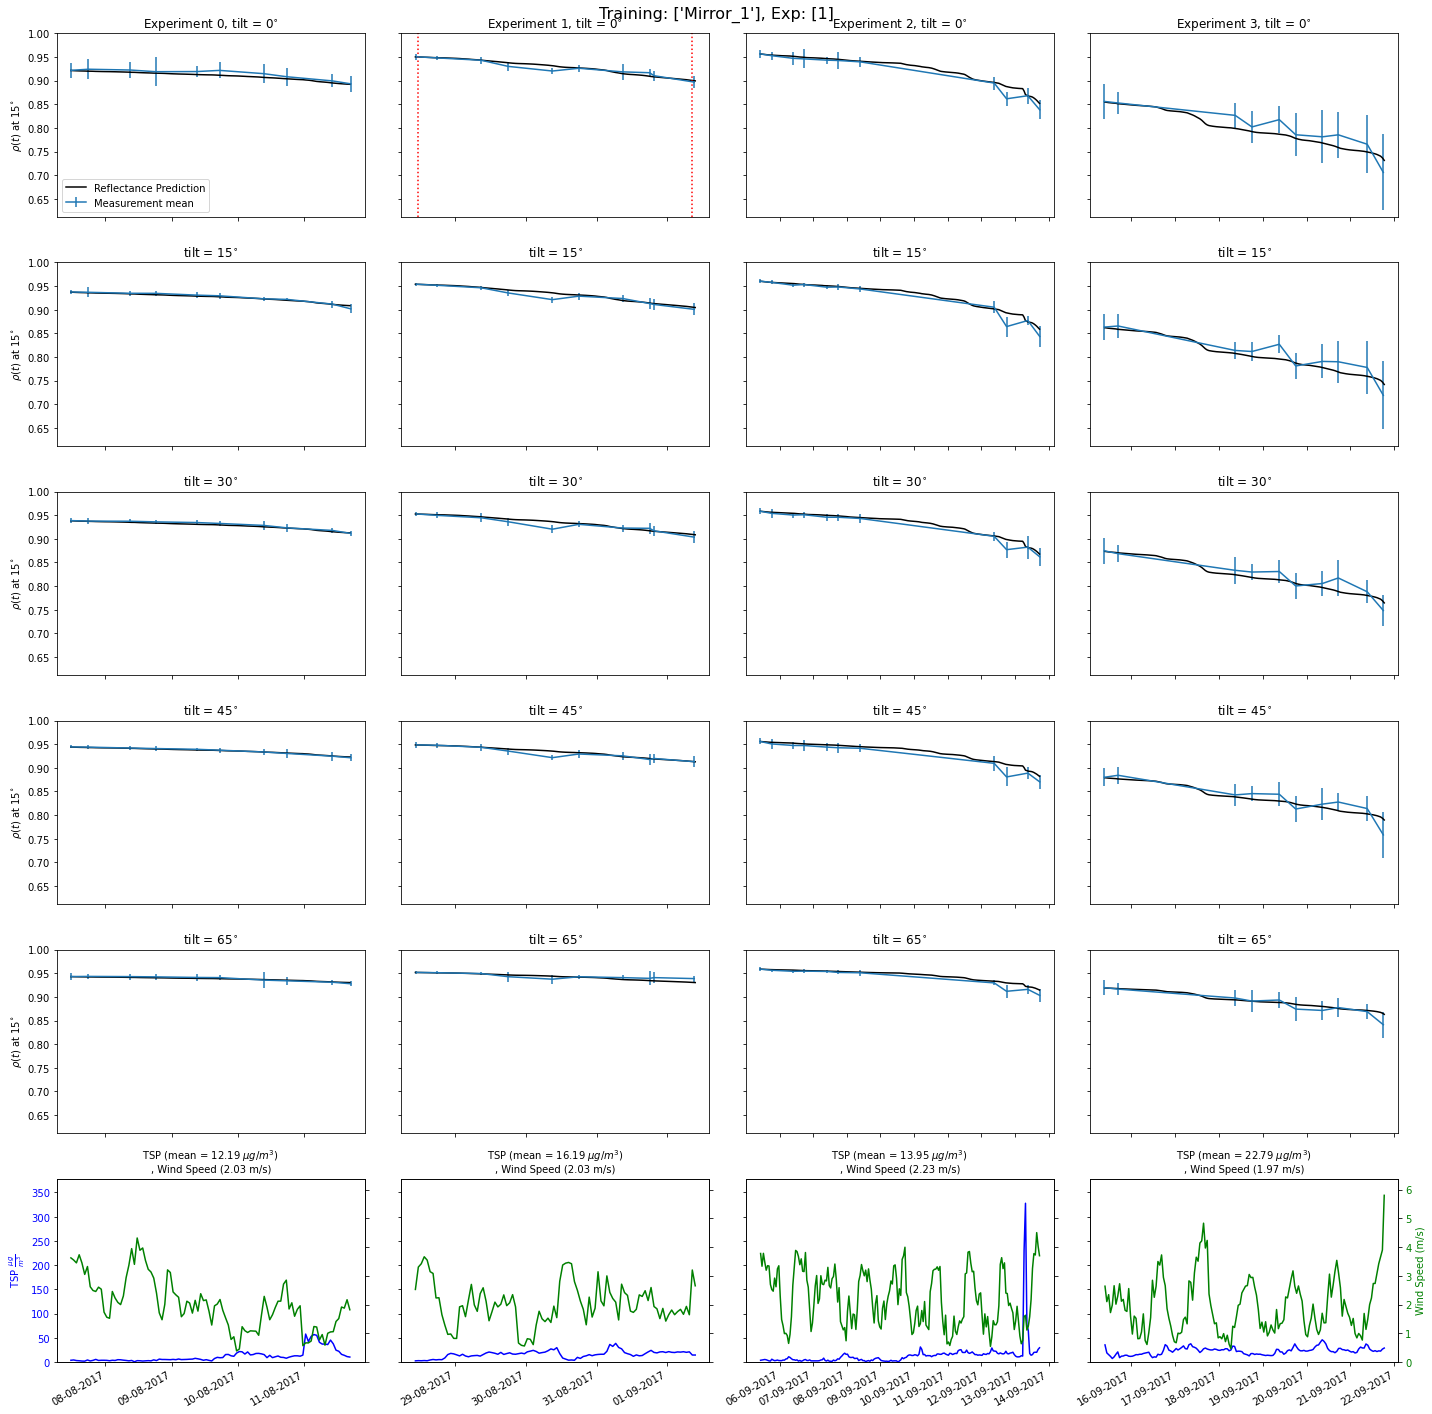

In [11]:
imodel.predict_reflectance(sim_data_total)
fig,ax,_,_,_  = imodel.plot_soiling_factor( sim_data_total,
                                            reflectance_data=reflect_data_total,
                                            figsize=(20,20),
                                            reflectance_std='measurements',
                                            fig_title=training_string,
                                            return_handles=True,
                                            repeat_y_labels=False)
# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')
fig.tight_layout()

# Parameter Estimation for the Stochastic Model

## Semi-physical model 

### Compute deposition velocity, angles, and Mie Extinction Weights

In [12]:
imodel.helios_angles(   sim_data_train,
                        reflect_data_train,
                        second_surface=second_surf)
                        
# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_train,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment_train))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Setting tilts for 1 experiments
Second surface model


### Fitting
Maximum Likelihood Estmation (MLE) or Maximum *A Posteriori* (MAP)

Getting inital hrz0 guess via least squares
Getting inital sigma_dep guess via MLE (at least-squares hrz0)
x0 = [1.815945434886682, 0.00027526138313831465]
Maximizing likelihood to obtain hrz0 and sigma_dep...
  Optimization terminated successfully.
Estimating parameter covariance using numerical approximation of Hessian ... 
... done! 
hrz0 = 1.85e+00, sigma_dep = 3.26e-04
95% confidence interval for hrz0: [1.27e+00, 2.43e+00]
95% confidence interval for sigma_dep: [1.39e-04, 5.12e-04]
No value for hrz0 supplied. Using value in self.hrz0 = 1.8500256859133875.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


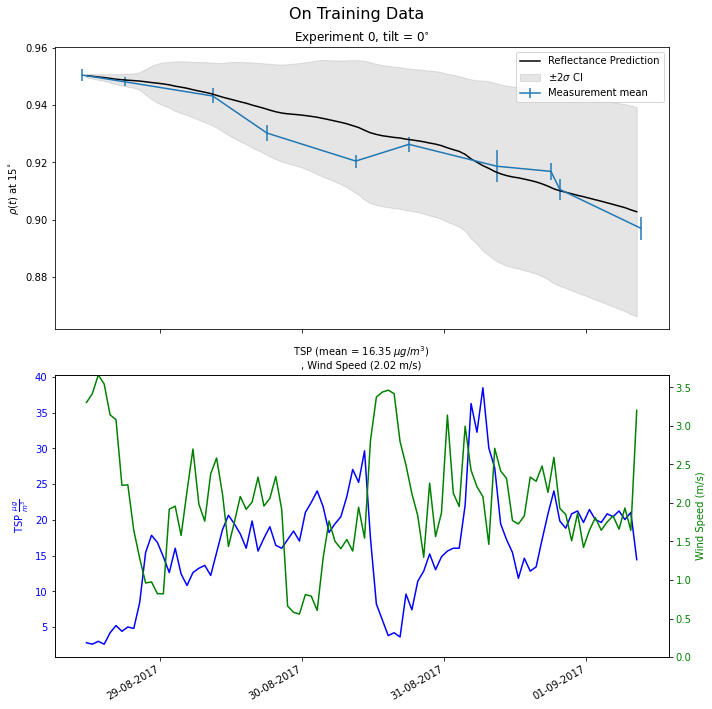

In [13]:

param_hat,param_cov = imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=True    )

# # MAP Fitting
# sigma_h = np.log(np.log(10.0))
# mu_h = np.log(np.log(2.0))
# sigma_sigma_dep = 5.0
# mu_sigma_dep = -2.0
# priors =    {   'log_log_hrz0': norm(scale=sigma_h,loc=mu_h),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#             }
# param_hat,param_cov = imodel.fit_map(   sim_data_train,
#                                         reflect_data_train,
#                                         priors,verbose=True,
#                                         transform_to_original_scale=True)


s = np.sqrt(np.diag(param_cov))
param_ci = param_hat + 1.96*s*np.array([[-1],[1]])
hrz0_mle,sigma_dep_mle = param_hat
imodel.update_model_parameters(param_hat)
imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
_,_,_ = imodel.plot_soiling_factor( sim_data_train,
                            reflectance_data=reflect_data_train,
                            figsize=(10,10),
                            reflectance_std='mean',
                            save_path="results/",
                            fig_title="On Training Data"    )

### Predict with test data and plot

In [14]:
imodel.helios_angles(   sim_data_total,
                        reflect_data_total,
                        second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_total,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


No value for hrz0 supplied. Using value in self.hrz0 = 1.8500256859133875.
Calculating deposition velocity for each of the 4 simulations
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
  No common stow_tilt. Use values in helios.tilt to compute removal moments. This might take some time.
Calculating soil deposited in a timestep [m^2/m^2]


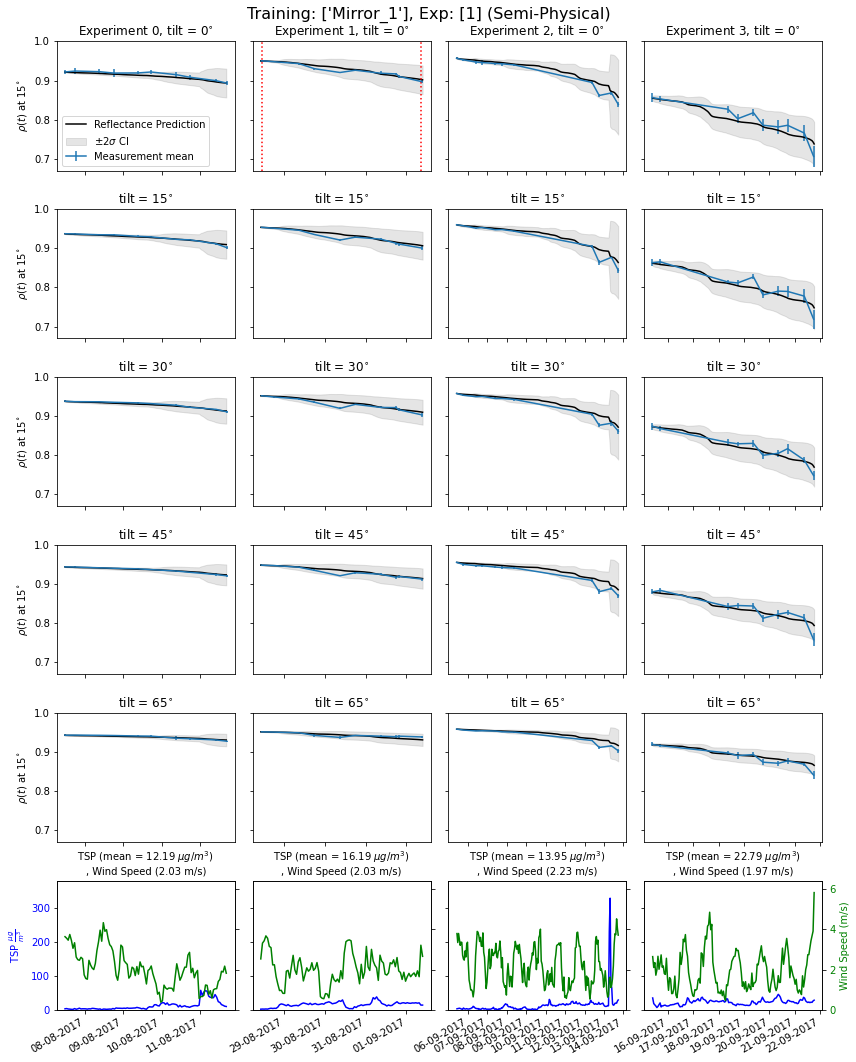

In [15]:
imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor
fig_total,ax_total,_,_,_   = imodel.plot_soiling_factor( sim_data_total,
                            reflectance_data=reflect_data_total,
                            figsize=(12,15),
                            reflectance_std='mean',
                            save_path="results/semi_physical_fitting.png",
                            fig_title=training_string+" (Semi-Physical)",
                            return_handles=True,
                            repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)

semi_physical_fitting_results = {
    'model':imodel,
    'simulation_data_train':sim_data_train,
    'reflectance_data_train':reflect_data_train,
    'simulation_data_total':sim_data_total,
    'reflectance_data_total':reflect_data_total,
}
with open(sp_save_file,"wb") as fid:
    pickle.dump(semi_physical_fitting_results,fid)

## Constant Mean Desposition Velocity
### Compute deposition velocity, angles, and Mie Extinction Weights

In [16]:
constant_imodel = smf.constant_mean_deposition_velocity(parameter_file)
constant_imodel.helios_angles(  sim_data_train,
                                reflect_data_train,
                                second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_train,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment_train))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)

Importing constants
Setting tilts for 1 experiments
Second surface model


### Fitting
MLE or MAP

Getting MLE estimates ... 
========== MLE Estimates ======== 
mu_tilde = 1.07e-04, sigma_dep = 2.97e-04
95% confidence interval for mu_tilde: [-6.06e+03, 6.06e+03]
95% confidence interval for sigma_dep: [-2.05e+03, 2.05e+03]


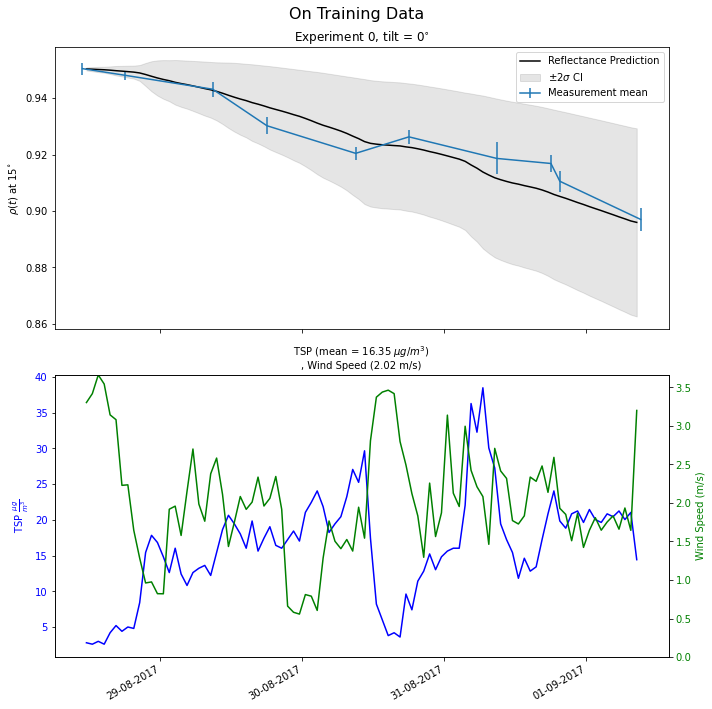

In [17]:
param_hat,param_cov = constant_imodel.fit_mle(   sim_data_train,
                                        reflect_data_train,
                                        transform_to_original_scale=True    )

# # MAP Fitting
# sigma_m = 1.5
# mu_m = -10.0
# sigma_sigma_dep = 5.0
# mu_sigma_dep = -2.0
# priors =    {   'log_mu_tilde': norm(scale=sigma_m,loc=mu_m),\
#                 'log_sigma_dep': norm(scale=sigma_sigma_dep,loc=mu_sigma_dep)\
#               }

# param_hat,param_cov = constant_imodel.fit_map(  sim_data_train,
#                                                 reflect_data_train,
#                                                 priors,verbose=True,
#                                                 transform_to_original_scale=True)


s = np.sqrt(np.diag(param_cov))
param_ci = param_hat + 1.96*s*np.array([[-1],[1]])
hrz0_mle,sigma_dep_mle = param_hat
constant_imodel.update_model_parameters(param_hat)
constant_imodel.predict_reflectance(sim_data_train) # writes output into imodel.helios.soiling_factor
_,_,_ = constant_imodel.plot_soiling_factor(    sim_data_train,
                                        reflectance_data=reflect_data_train,
                                        figsize=(10,10),
                                        reflectance_std='mean',
                                        save_path="results/",
                                        fig_title="On Training Data"    )

### Predict with test data and plot

In [18]:
constant_imodel.helios_angles(  sim_data_total,
                                reflect_data_total,
                                second_surface=second_surf)

# Use the below if extinction weights are not necessarily the same for each file
# imodel.helios.compute_extinction_weights(   sim_data_total,
#                                             imodel.loss_model,
#                                             verbose=True
#                                             )

# case where extinction weights are known to be the same as the ext_weights from the training file
file_inds = np.arange(len(files_experiment))
imodel = smu.set_extinction_coefficients(imodel,ext_weights,file_inds)
                        
constant_imodel.predict_reflectance(sim_data_total) # writes output into imodel.helios.soiling_factor

Setting tilts for 4 experiments
Second surface model
Second surface model
Second surface model
Second surface model


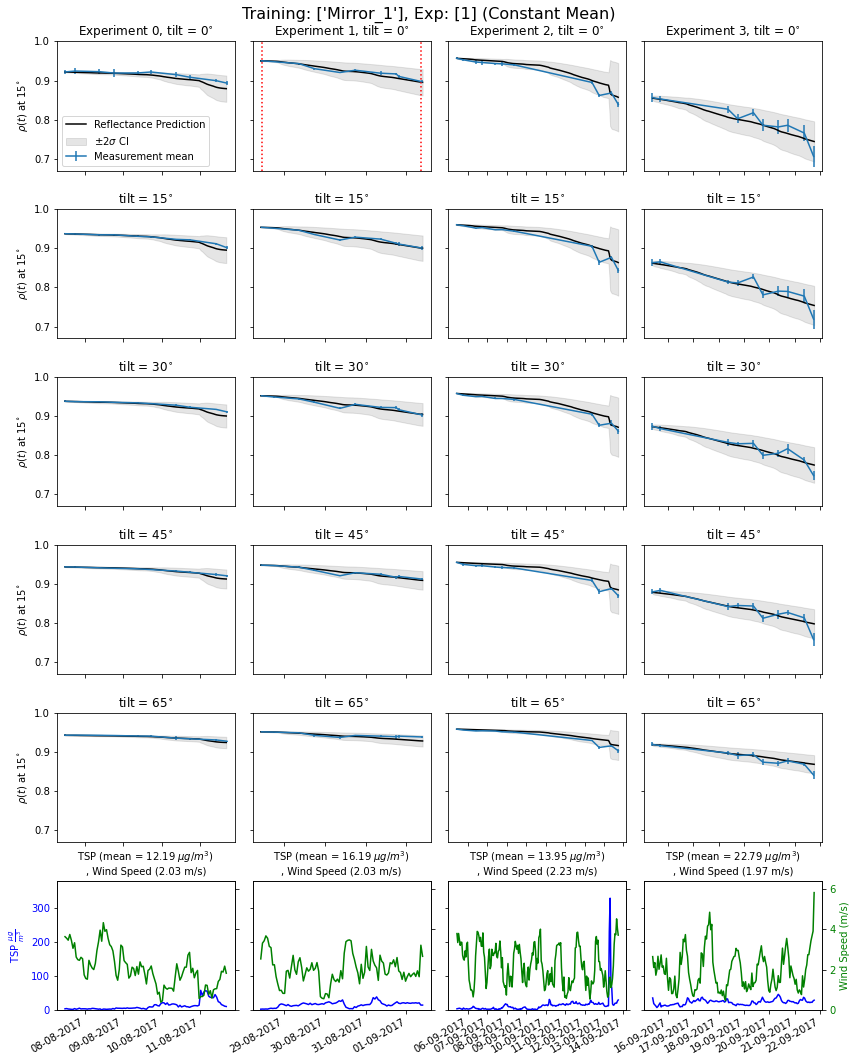

In [19]:
fig_total,ax_total,_,_,_   = constant_imodel.plot_soiling_factor(   sim_data_total,
                                                                    reflectance_data=reflect_data_total,
                                                                    figsize=(12,15),
                                                                    reflectance_std='mean',
                                                                    save_path="results/constant_mean_fitting.png",
                                                                    fig_title=training_string+" (Constant Mean)",
                                                                    return_handles=True,
                                                                    repeat_y_labels=False)

# add lines indicating training times for mirrors 
# and experiments use for training.
for ii,e in enumerate(train_experiments):
    for jj,m in enumerate(all_mirrors):
        if m in train_mirrors:
            a = ax_total[jj,e]
            a.axvline(x=sim_data_train.time[ii][0],ls=':',color='red')
            a.axvline(x=sim_data_train.time[ii][-1],ls=':',color='red')

fig_total.subplots_adjust(wspace=0.1, hspace=0.3)
